## Eager execution 


“一个类似NumPy的数值计算库，支持GPU加速和自动区分，以及灵活的机器学习研究和实验平台。”

开启Eager function模式，你不再需要担心：

- 占位符
- 会话
- 控制依赖
- “懒加载”
- {name，variable，op}范围

### 示例子1

#### 未开启Eager

In [ ]:
x = tf.placeholder(tf.float32, shape=[1, 1])
m = tf.matmul(x, x)
print(m)# Tensor("MatMul:0", shape=(1, 1), dtype=float32)
with tf.Session() as sess:
    m_out = sess.run(m, feed_dict={x: [[2.]]})
    print(m_out)# [[4.]]

#### 开启Eager

In [ ]:
x = [[2.]]  # No need for placeholders!
m = tf.matmul(x, x)
print(m)  # No sessions!
# tf.Tensor([[4.]], shape=(1, 1), dtype=float32)

启用Eager执行后，这3行提供相同的效果。没有会话，没有占位符和matmul操作立即提供值。

### 示例2

#### 未开启Eager

In [ ]:
x = tf.random_uniform([2, 2])
with tf.Session() as sess:
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            print(sess.run(x[i, j]))

#### 开启Eager

In [ ]:
x = tf.random_uniform([2, 2])
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        print(x[i, j])


急切的执行也有助于避免陷入元编程的绊脚石。

例如，这里的代码是人们可能在他们的程序中快速破解以分析Tensor x的代码。
它很容易被遗漏，但循环的每次迭代都会向图的内存中表示添加操作

在这种特殊情况下，还有一个事实是每次调用session.run都在执行random_uniform操作，因此这里的代码片段不会打印张量的一致快照。


在启用了急切执行的情况下，没有图形概念或操作的重复执行，因此最明显的处理方式非常有效。

### 示例3

#### Tensors Act Like NumPy Arrays

In [ ]:
x = tf.constant([1.0, 2.0, 3.0])
# Tensors are backed by NumPy arrays
assert type(x.numpy()) == np.ndarray
squared = np.square(x) # Tensors are compatible with NumPy functions
 
# Tensors are iterable!
for i in x:
    print(i)

for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        print(x[i, j])


## Gradients(梯度)

开启Eager模式后，正向传播很直观很好理解，但应该怎么求梯度呢？

在tfe中共有四个函数直接服务于反向传播，它们是：

- tfe.gradients_function
- tfe.value_and_gradients_function
- tfe.implicit_gradients
- tfe.implicit_value_and_gradients

In [ ]:
上面四个函数类似于python的装饰器，例如：

@tfe.gradients_function
def f(x, y):
    return x ** 2 + y ** 3
f(1., 2.)

In [ ]:
上面就是装饰器函数的一个典型语法，上面可以等价于：
def f(x, y):
    return x ** 2 + y ** 3
g = tfe.gradients_function(f)
g(1., 2.)

求导后为：dx=2x,dy=3x^2,则g(1.,2.)=(2,12)

`tfe.gradients_function`的输入是一个函数，输出是**输入函数相对于它所有参数的梯度函数**。

`tfe.gradients_function`的功能是**对函数的输入参数求导**，

但在实际使用中，我们希望对TensorFlow中的变量（Variable）求导，

因为变量中保存的是模型的参数，这才是我们真正要优化、做梯度下降的部分。

`tfe.implicit_gradients`的功能就是**生成可以对“计算过程中所有用到的变量”求导的函数**。

In [ ]:
x = tfe.Variable(initial_value=1.0, name="x")
y = tfe.Variable(initial_value=1.0, name="y")
def f(t):
    return 2 * x * t
g = tfe.implicit_gradients(f)
g(1.)

上面定义两个变量x和y，只用了x这个变量，所以只会对vx求导！g的返回值是一个列表，列表中以(梯度，变量值)的形式存储了所有计算的梯度的值和变量的值。这里就应当是[(2, 1)]。

如果需要同时获取f的值和f的梯度，就可以分别用`tfe.value_and_gradients_function`和`tfe.implicit_value_and_gradients`取代`tfe.gradients_function`、`tfe.implicit_gradient`。

原先`tfe.gradients_function`返回的是梯度，`tfe.value_and_gradients_function`返回的就是(函数值，梯度)。

原先`tfe.implicit_gradient`返回的是(梯度，变量值)，`tfe.implicit_value_and_gradients`返回的就是(函数值，梯度)。

将求出的梯度应用到变量上：
```python
def loss_fn(...):
    ....
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
value_and_gradients_fn = tfe.implicit_value_and_gradients(loss_fn)
empirical_loss, gradients_and_variables = value_and_gradients_fn(.....)
optimizer.apply_gradients(gradients_and_variables)
```
参考自https://www.zhihu.com/question/67471378/answer/253549074

### 缺点

开启Eager模式后用tf.placeholder甚至会直接报错！不能用tf.Variable创建变量，而是要用tf.get_variable()或者tfe.Variable()来创建。

### 什么时候使用Eager Function

- 研究员，想要一个灵活的框架
    - python控制流和数据结构实现了实验
- 开发新模型
    - 即时错误报告简化了调试
- TensorFlow新手
    - 热切的执行使您可以在Python REPL中探索TF API

## Eager Execution


“一个类似NumPy的数值计算库，支持GPU加速和自动区分，以及灵活的机器学习研究和实验平台。”

In [1]:
import time 
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import matplotlib.pyplot as plt

import utils

DATA_FILE = './birth_life_2010.txt'
tfe.enable_eager_execution()

In [4]:
data,n_samples = utils.read_birth_life_data(DATA_FILE)
dataset = tf.data.Dataset.from_tensor_slices((data[:,0],data[:,1]))

不能用tf.Variable创建变量，而是要用tf.get_variable()或者tfe.Variable()来创建

In [6]:
# w = tf.Variable(0.0)
# b = tf.Variable(0.0)
'''
tf.Variable not supported when eager execution is enabled. 
Please use tf.contrib.eager.Variable instead
'''
w = tfe.Variable(0.0)
b = tfe.Variable(0.0)

In [13]:
def prediction(x):
    return x*w+b

In [14]:
def squared_loss(y,y_predicted):
    return (y-y_predicted)**2

def huber_loss(y,y_predicted,m=1.0):
    t = y-y_predicted
    return 0.5*t**2 if tf.abs(t)<=m else m*(tf.abs(t)-0.5*m)

In [9]:
# 原先的huber_loss
def huber_loss1(label, prediction, delta=14.0):
    residual = tf.abs(label - prediction)
    def f1(): return 0.5*tf.square(residual)
    def f2(): return delta*residual-0.5*tf.square(delta)
    return tf.cond(residual < delta, f1,f2)
# cond函数分为true和false两种情况。在许多情况下，使用函数tf.case。

In [15]:
def train(loss_fn):
    print('Training:loss function: ' + loss_fn.__name__)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
    def loss_for_example(x,y):
        return loss_fn(y,prediction(x))
    
    # 储存值与梯度
    grad_fn = tfe.implicit_value_and_gradients(loss_for_example)
    start = time.time()
    for epoch in range(100):
        total_loss=0.0
        for x_i,y_i in tfe.Iterator(dataset):
            loss,gradients = grad_fn(x_i,y_i)
            optimizer.apply_gradients(gradients)
            total_loss+=loss
        if epoch%10==0:
            print('Epoch {0}:{1}'.format(epoch,total_loss/n_samples))
    print('Took:%f seconds'%(time.time()-start))
    print('Eager execution exhibits significant overhead per operation. '
        'As you increase your batch size, the impact of the overhead will '
        'become less noticeable. Eager execution is under active development: '
        'expect performance to increase substantially in the near future!')

In [16]:
train(huber_loss)

Training:loss function: huber_loss
Epoch 0:60.69637680053711
Epoch 10:29.98884391784668
Epoch 20:27.12620735168457
Epoch 30:24.31956672668457
Epoch 40:21.523069381713867
Epoch 50:18.747325897216797
Epoch 60:16.022245407104492
Epoch 70:13.383048057556152
Epoch 80:10.830995559692383
Epoch 90:8.40764045715332
Took:32.411659 seconds
Eager execution exhibits significant overhead per operation. As you increase your batch size, the impact of the overhead will become less noticeable. Eager execution is under active development: expect performance to increase substantially in the near future!


张量的`.numpy（）`方法检索支持它的NumPy数组。在未来的eager版本中，你不需要调用`.numpy（）`而且会在大多数情况下，能够在NumPy数组所在的地方传递张量。

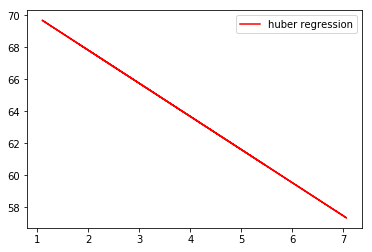

In [21]:
plt.plot(data[:,0], data[:,0] * w.numpy() + b.numpy(), 'r',
         label="huber regression")
plt.legend()